# Informações do projeto

## Aluno

**Nome:** Felipe Nunes de Almeida Pereira (fnap@cin.ufpe.br)

**Github:** fnalmeidap

## Dataset

O dataset escolhido foi o Stellar Classification Dataset - SDSS17 (https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17). Ele contém 100 mil observações telescópicas do espaço vindas do projeto SDSS (SLoan Digital Sky Survey). Cada observação tem 17 features e uma única classe que identifica o objeto observado como estrela, galáxia ou quasar. 

    obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
    alpha = Right Ascension angle (at J2000 epoch)
    delta = Declination angle (at J2000 epoch)
    u = Ultraviolet filter in the photometric system
    g = Green filter in the photometric system
    r = Red filter in the photometric system
    i = Near Infrared filter in the photometric system
    z = Infrared filter in the photometric system
    run_ID = Run Number used to identify the specific scan
    rereun_ID = Rerun Number to specify how the image was processed
    cam_col = Camera column to identify the scanline within the run
    field_ID = Field number to identify each field
    spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
    class = object class (galaxy, star or quasar object)
    redshift = redshift value based on the increase in wavelength
    plate = plate ID, identifies each plate in SDSS
    MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
    fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

## Objetivo do projeto
- Explorar o dataset e descrever suas medidas de:
    - Valor central
    - Variabilidade
    - Relativas
- Construir quatro modelos de classificação do dado categórico nominal COSMIC_CLASS = {GALAXY, QUASAR, STAR}
- Utilizar o auto-sklearn e clusterização para entendimento dos dados.
- Separar os dados em treinamento, validação e teste
- Escolher quatro algoritmos de classificação
- Adicionar MLFlow no treinamento de modelos para rastreamento
- Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação
- Diagnosticar melhor modelo e melhorá-lo



## Imports

In [21]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import mlflow
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn  import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from autosklearn.classification import AutoSklearnClassifier 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV

sns.set(style = "darkgrid")
sns.set_palette("Paired")


# Análise exploratória de dados

## Descrição de dados

In [2]:
stellar_data = pd.read_csv('data_project_2/star_classification.csv')
stellar_data.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [3]:
stellar_data.rename({"class":"COSMIC_CLASS"}, axis=1, inplace=True)
stellar_data.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,COSMIC_CLASS,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [7]:
stellar_data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [8]:
stellar_data.dtypes

obj_ID          float64
alpha           float64
delta           float64
u               float64
g               float64
r               float64
i               float64
z               float64
run_ID            int64
rerun_ID          int64
cam_col           int64
field_ID          int64
spec_obj_ID     float64
COSMIC_CLASS     object
redshift        float64
plate             int64
MJD               int64
fiber_ID          int64
dtype: object

In [9]:
stellar_data.isnull().sum()

obj_ID          0
alpha           0
delta           0
u               0
g               0
r               0
i               0
z               0
run_ID          0
rerun_ID        0
cam_col         0
field_ID        0
spec_obj_ID     0
COSMIC_CLASS    0
redshift        0
plate           0
MJD             0
fiber_ID        0
dtype: int64

## Discretização de dados categóricos

**GALAXY** = 0

**STAR** = 1

**QUASAR** = 2

In [4]:
def getCategory(number: int) -> str:
    if number == 0:
        return "GALAXY"
    elif number == 1:
        return "STAR"
    elif number == 2:
        return "QSO"
    else:
        raise ValueError("Invalid value")

In [5]:
stellar_data["COSMIC_CLASS"] = [0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in stellar_data["COSMIC_CLASS"]]
stellar_data.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,COSMIC_CLASS,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0,0.116123,6121,56187,842


## Removendo outliers.

In [6]:
weird_values = stellar_data[
    (stellar_data['u'] < -100) & 
    (stellar_data['g'] < -100) &
    (stellar_data['z'] < -100)
]
weird_index = weird_values.index

In [7]:
stellar_data.drop(weird_index, inplace=True)

## Visualização de dados

<AxesSubplot: xlabel='COSMIC_CLASS', ylabel='count'>

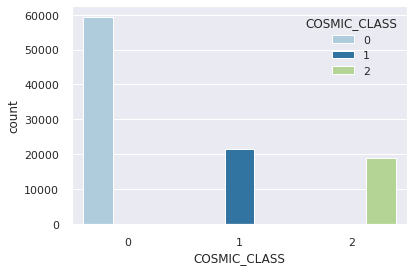

In [8]:
sns.countplot(x='COSMIC_CLASS', data=stellar_data, hue='COSMIC_CLASS')

<AxesSubplot: xlabel='alpha', ylabel='delta'>

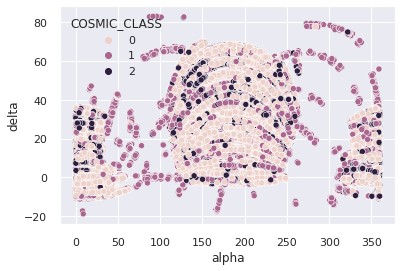

In [12]:
sns.scatterplot(x='alpha', y='delta', data=stellar_data, hue='COSMIC_CLASS')

### Verificando outliers nos dados do espectro eletromagnético

In [94]:
spectrum = stellar_data[['u','g','r','i','z','redshift','COSMIC_CLASS']]
spectrum.head(5)

,u,g,r,i,z,redshift,COSMIC_CLASS
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,0
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,0
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,0
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,0
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,0


<AxesSubplot: >

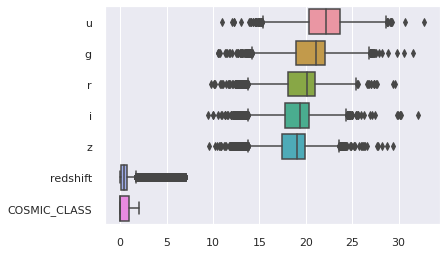

In [95]:
sns.boxplot(data=spectrum, orient='h')

<AxesSubplot: xlabel='redshift', ylabel='COSMIC_CLASS'>

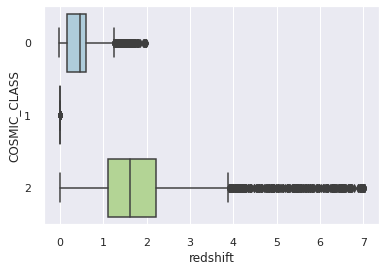

In [15]:
sns.boxplot(data=spectrum, x=spectrum['redshift'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='u', ylabel='COSMIC_CLASS'>

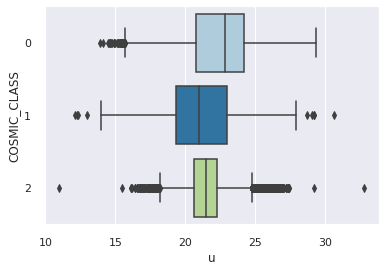

In [16]:
sns.boxplot(data=spectrum, x=spectrum['u'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='g', ylabel='COSMIC_CLASS'>

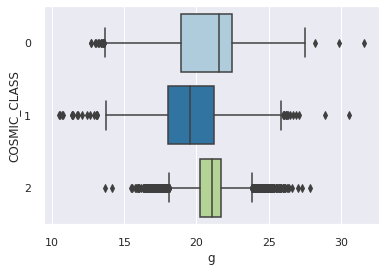

In [17]:
sns.boxplot(data=spectrum, x=spectrum['g'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='r', ylabel='COSMIC_CLASS'>

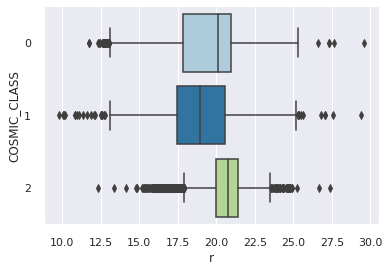

In [18]:
sns.boxplot(data=spectrum, x=spectrum['r'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='i', ylabel='COSMIC_CLASS'>

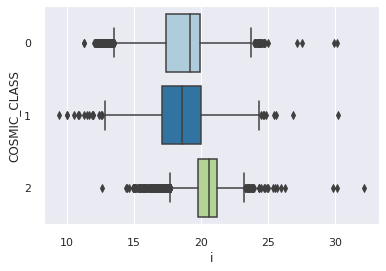

In [19]:
sns.boxplot(data=spectrum, x=spectrum['i'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='z', ylabel='COSMIC_CLASS'>

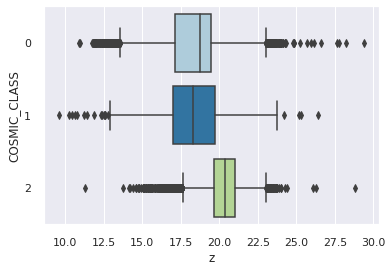

In [20]:
sns.boxplot(data=spectrum, x=spectrum['z'], y='COSMIC_CLASS', orient = 'h')

# Modelos

## Análise de features numéricas

In [21]:
# Correlação
correlation_dataframe = stellar_data.corr()
correlation_dataframe

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,COSMIC_CLASS,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013726,-0.301268,0.131567,0.151478,0.153879,0.147661,0.140463,1.000000,NaN,-0.047016,0.031544,0.239454,-0.000038,0.065387,0.239453,0.262686,0.067159
alpha,-0.013726,1.000000,0.138698,-0.000222,-0.014118,-0.022079,-0.023577,-0.025160,-0.013728,NaN,0.019587,-0.165593,-0.002550,0.004549,0.001671,-0.002551,0.019945,0.030469
delta,-0.301268,0.138698,1.000000,-0.026845,-0.007077,-0.006845,-0.004488,-0.006286,-0.301270,NaN,0.032553,-0.173393,0.112322,0.056650,0.031629,0.112322,0.107330,0.028237
u,0.131567,-0.000222,-0.026845,1.000000,0.853350,0.728681,0.618346,0.545760,0.131566,NaN,0.007673,-0.013365,0.395856,-0.226930,0.166816,0.395854,0.436346,0.183174
g,0.151478,-0.014118,-0.007077,0.853350,1.000000,0.932996,0.847046,0.775302,0.151477,NaN,0.007828,-0.022149,0.584317,-0.066894,0.318910,0.584315,0.610809,0.220396
r,0.153879,-0.022079,-0.006845,0.728681,0.932996,1.000000,0.962868,0.919114,0.153878,NaN,0.008472,-0.026405,0.655243,0.150696,0.433237,0.655242,0.671180,0.223100
i,0.147661,-0.023577,-0.004488,0.618346,0.847046,0.962868,1.000000,0.971546,0.147660,NaN,0.007609,-0.026665,0.661640,0.284400,0.492381,0.661639,0.672522,0.214782
z,0.140463,-0.025160,-0.006286,0.545760,0.775302,0.919114,0.971546,1.000000,0.140461,NaN,0.006416,-0.026377,0.644332,0.340914,0.501060,0.644331,0.653784,0.203730
run_ID,1.000000,-0.013728,-0.301270,0.131566,0.151477,0.153878,0.147660,0.140461,1.000000,NaN,-0.047117,0.031544,0.239453,-0.000039,0.065386,0.239453,0.262685,0.067147
rerun_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


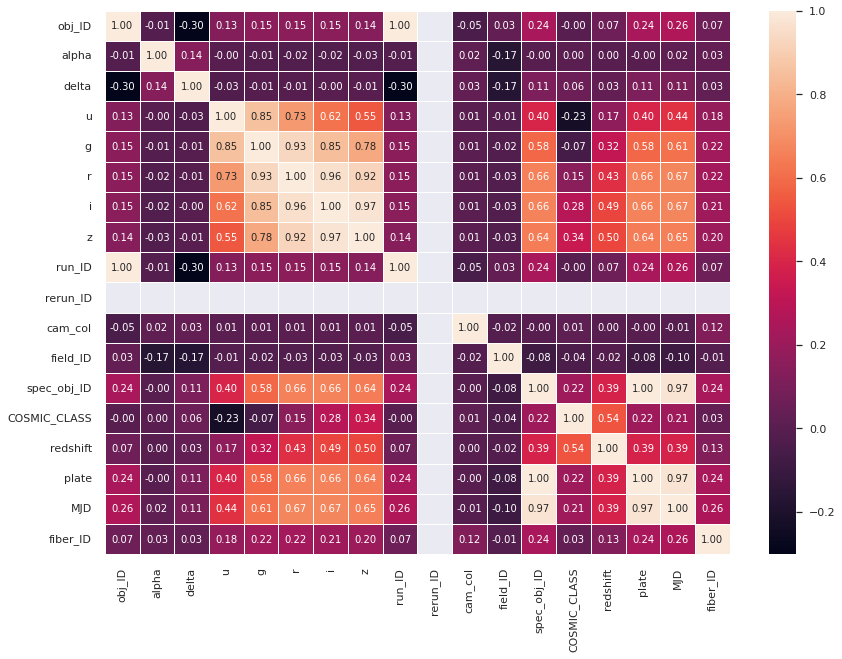

In [22]:
plt.figure(figsize = (14,10))
sns.heatmap(stellar_data.corr(), annot = True, fmt = ".2f", linewidths = 1)
plt.show()



In [23]:
stellar_corr = stellar_data.corr()
stellar_corr['COSMIC_CLASS'].sort_values(ascending=False)

COSMIC_CLASS    1.000000
redshift        0.536829
z               0.340914
i               0.284400
plate           0.215726
spec_obj_ID     0.215726
MJD             0.207264
r               0.150696
delta           0.056650
fiber_ID        0.032059
cam_col         0.014481
alpha           0.004549
obj_ID         -0.000038
run_ID         -0.000039
field_ID       -0.038057
g              -0.066894
u              -0.226930
rerun_ID             NaN
Name: COSMIC_CLASS, dtype: float64

### Removendo colunas indesejadas

In [9]:
stellar_data.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1, inplace = True)
stellar_data.head(5)

,u,g,r,i,z,spec_obj_ID,COSMIC_CLASS,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0,0.779136,10445,58158
2,25.26307,22.66389,20.60976,19.34857,18.94827,5.152200e+18,0,0.644195,4576,55592
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0,0.116123,6121,56187


In [10]:
x = stellar_data.drop(['COSMIC_CLASS'], axis = 1)
y = stellar_data.loc[:,'COSMIC_CLASS'].values

### Fazendo resampling

In [11]:
smote = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
x, y = smote.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 59445, 1: 21593, 2: 18961})
Resampled dataset shape Counter({0: 59445, 2: 59445, 1: 59445})


/home/felipenunes/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


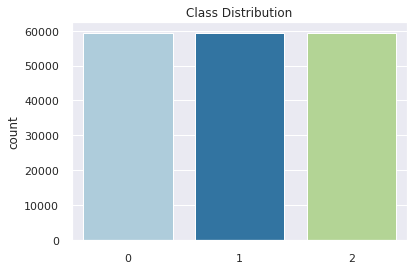

In [12]:
sns.countplot(y)
plt.title("Class Distribution")
plt.show()

## Separação entre dados de teste e de treino. 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [14]:
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

x_train: (119484, 9)
x_test: (58851, 9)
y_train: (119484,)
y_test: (58851,)


## Modelos

In [15]:
classes = [0, 1, 2]

### Random forest

In [30]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
predict = random_forest.predict(x_test)
score = random_forest.score(x_test, y_test)
random_forest_score = np.mean(score)

print(f'Accuracy: {random_forest_score}')

Accuracy: 0.9829909432295119


##### Matriz de confusão

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


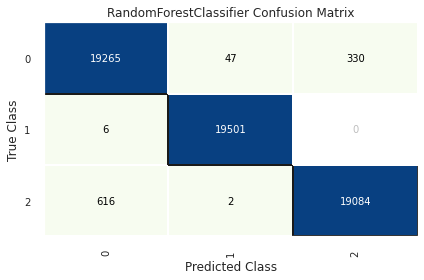

<AxesSubplot: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [31]:
r_forest_cm = ConfusionMatrix(random_forest, classes=classes, cmap='GnBu')

r_forest_cm.fit(x_train, y_train)
r_forest_cm.score(x_test, y_test)
r_forest_cm.show()

In [32]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     19642
           1       1.00      1.00      1.00     19507
           2       0.98      0.97      0.98     19702

    accuracy                           0.98     58851
   macro avg       0.98      0.98      0.98     58851
weighted avg       0.98      0.98      0.98     58851



##### Curva ROC

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


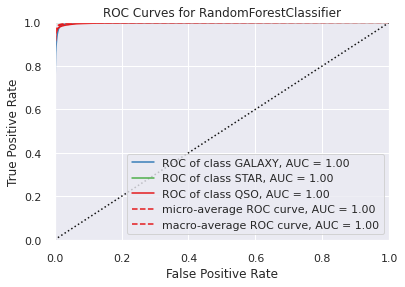

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [36]:
visualizer = ROCAUC(random_forest, classes=["GALAXY", "STAR", "QSO"])

set_palette('bold')

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)        
visualizer.show()        

##### Class prediction error

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


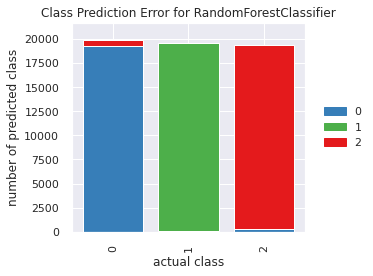

<AxesSubplot: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [37]:
visualizer = ClassPredictionError(random_forest, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show() 

### Regressão logística


In [103]:
logistic_regression = LogisticRegression(max_iter=2500)
logistic_regression.fit(x_train,np.ravel(y_train))
y_predicted_lr = logistic_regression.predict(x_test)
logistic_regression_score = logistic_regression.score(x_test, y_test)

print(f'Accuracy: {logistic_regression_score}')

Accuracy: 0.33477765883332483


#### Matriz de confusão

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


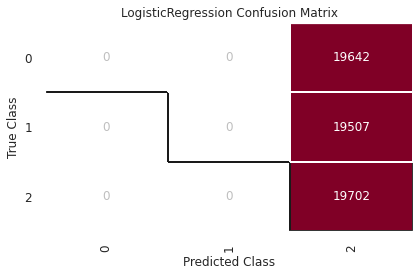

In [98]:
logistic_regression_cm = ConfusionMatrix(logistic_regression, classes=classes)
logistic_regression_cm.fit(x_train, y_train)
logistic_regression_cm.score(x_test, y_test)
logistic_regression_cm.show()

random_forest_score = np.mean(score)

In [100]:
print(classification_report(y_test, y_predicted_lr))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19642
           1       0.00      0.00      0.00     19507
           2       0.33      1.00      0.50     19702

    accuracy                           0.33     58851
   macro avg       0.11      0.33      0.17     58851
weighted avg       0.11      0.33      0.17     58851



/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### Curva ROC

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


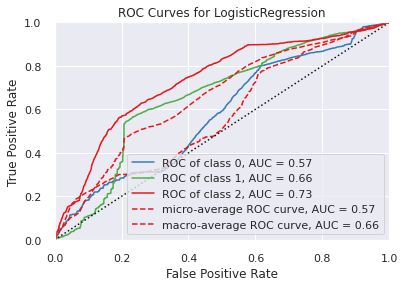

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [101]:
visualizer = ROCAUC(logistic_regression, classes=classes)
set_palette('bold')
visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()   

#### Class prediction error

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


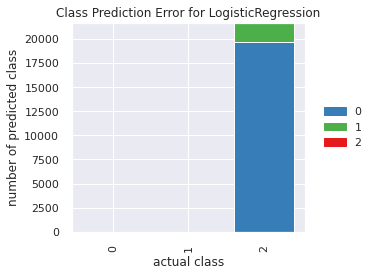

<AxesSubplot: title={'center': 'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [102]:
visualizer = ClassPredictionError(logistic_regression, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show() 

### K-Nearest Neighbors

In [56]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
y_predicted_knn = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)
print('Accuracy : %.3f' % (knn_score_))

Accuracy : 0.680


#### Matriz de confusão

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


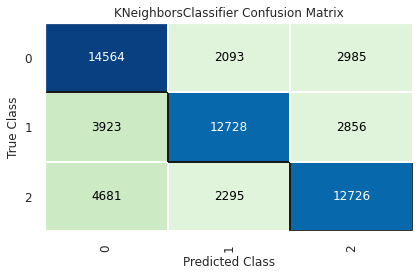

<AxesSubplot: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [58]:
KNN_cm = ConfusionMatrix(knn, classes=classes, cmap='GnBu')
KNN_cm.fit(x_train, y_train)
KNN_cm.score(x_test, y_test)
KNN_cm.show()

In [59]:
print(classification_report(y_test, y_predicted_knn))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     19642
           1       0.74      0.65      0.70     19507
           2       0.69      0.65      0.67     19702

    accuracy                           0.68     58851
   macro avg       0.69      0.68      0.68     58851
weighted avg       0.69      0.68      0.68     58851



#### Curva ROC

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


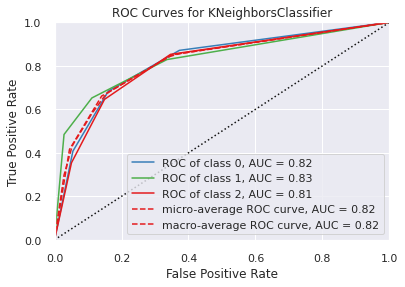

<AxesSubplot: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [60]:
visualizer = ROCAUC(knn, classes=classes)
set_palette('bold')
visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()   

#### Class prediction error

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


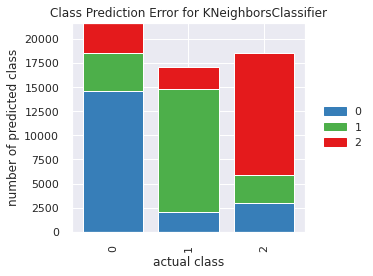

<AxesSubplot: title={'center': 'Class Prediction Error for KNeighborsClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [61]:
visualizer = ClassPredictionError(knn, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show() 

### Support Vector Machine (SVM)

In [106]:
support_vector_machine = svm.SVC(kernel='rbf', C=10, random_state=42)
support_vector_machine.fit(x_train,y_train)
predicted = support_vector_machine.predict(x_test)
score = support_vector_machine.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.528


#### Confusion matrix

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


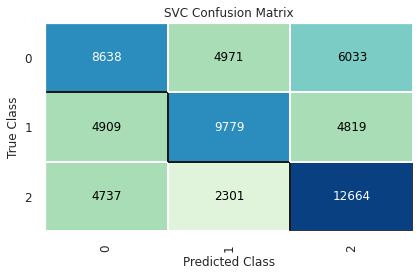

<AxesSubplot: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [107]:
svm_cm = ConfusionMatrix(support_vector_machine, classes=classes, cmap='GnBu')
svm_cm.fit(x_train, y_train)
svm_cm.score(x_test, y_test)
svm_cm.show()

In [108]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.47      0.44      0.46     19642
           1       0.57      0.50      0.53     19507
           2       0.54      0.64      0.59     19702

    accuracy                           0.53     58851
   macro avg       0.53      0.53      0.53     58851
weighted avg       0.53      0.53      0.53     58851



#### Curva ROC

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


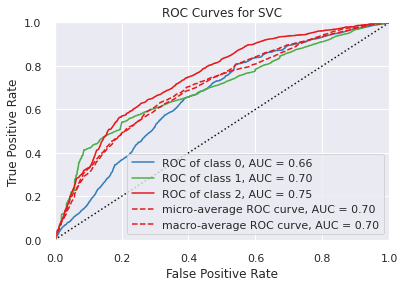

<AxesSubplot: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [109]:
visualizer = ROCAUC(support_vector_machine, classes=classes)
set_palette('bold')
visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()   

#### Class prediction error

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


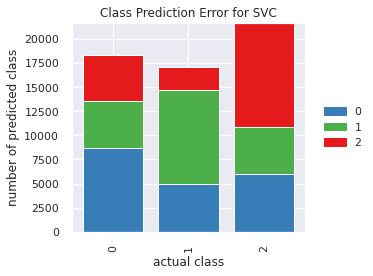

<AxesSubplot: title={'center': 'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [110]:
visualizer = ClassPredictionError(support_vector_machine, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show() 

### Decision Tree

In [112]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train, y_train)
y_predicted_dt = decision_tree.predict(x_test)
score = decision_tree.score(x_test, y_test)
decision_tree_score = np.mean(score)

print('Accuracy : %.3f' % (decision_tree_score))

Accuracy : 0.973


#### Confusion matrix

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


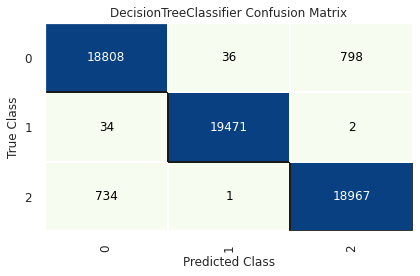

<AxesSubplot: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [114]:
decision_tree_cm = ConfusionMatrix(decision_tree, classes=classes, cmap='GnBu')
decision_tree_cm.fit(x_train, y_train)
decision_tree_cm.score(x_test, y_test)
decision_tree_cm.show()

In [115]:
print(classification_report(y_test, y_predicted_dt))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19642
           1       1.00      1.00      1.00     19507
           2       0.96      0.96      0.96     19702

    accuracy                           0.97     58851
   macro avg       0.97      0.97      0.97     58851
weighted avg       0.97      0.97      0.97     58851



#### Curva ROC

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


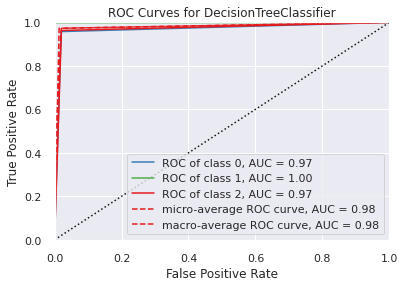

<AxesSubplot: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [116]:
visualizer = ROCAUC(decision_tree, classes=classes)
set_palette('bold')
visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()   

#### Class prediction error

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


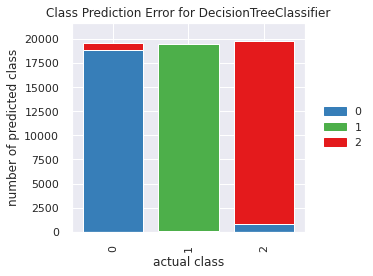

<AxesSubplot: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [117]:
visualizer = ClassPredictionError(decision_tree, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show() 

## Auto sklearn

In [21]:
auto_model = AutoSklearnClassifier()
auto_model.fit(x_train, y_train)
y_predicted_auto = auto_model.predict(x_test)

init_dgesdd failed init
init_dgesdd failed init
init_dgesdd failed init


NameError: name 'score' is not defined

In [23]:
print(auto_model.sprint_statistics())

auto-sklearn results:
  Dataset name: a0ed48dd-4288-11ed-945d-d1b432a75892
  Metric: accuracy
  Best validation score: 0.982146
  Number of target algorithm runs: 39
  Number of successful target algorithm runs: 33
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 0



## MLFlow

#### Helper functions

In [18]:
def eval_metrics(actual, pred):
        f1 = f1_score(actual,pred, average = 'micro')
        precision = precision_score(actual, pred, average = 'micro')
        recall = recall_score(actual, pred, average = 'micro')
        acc = accuracy_score(actual, pred)
        return f1, precision, recall, acc

def train_model(model, args, name):

  with mlflow.start_run():
    model = model(**args)
    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
        
    f1, precision, recall, accuracy = eval_metrics(y_test, y_pred)
    score = cross_val_score(model, x_train, y_train, cv=3, scoring='accuracy').mean()
    log = name
    for key in args:
        log += f' {args[key]}'

    for key in args:
      if key != 'name':
        mlflow.log_param(key, args[key])  
    
    mlflow.log_metric("f1score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric('cross_score', score)

    mlflow.sklearn.log_model(model, name)

def run_experiment(model, params, list_values, name):
  mlflow.set_experiment(name)

  args = {}
  import itertools
  combination_params = list(itertools.product(*list_params))
  count = 1
  for a,b,c in combination_params:
    args[params[0]] = a
    args[params[1]] = b
    args[params[2]] = c
    train_model(model, args, name)
    print(f'{count}/{len(combination_params)}')
    count+=1

In [39]:
mlflow.set_experiment('My experiment')

<Experiment: artifact_location='file:///home/felipenunes/Workplace/personal/github/data-sci/project_2/mlruns/3', creation_time=1664744608654, experiment_id='3', last_update_time=1664744608654, lifecycle_stage='active', name='My experiment', tags={}>

#### Random forest

In [48]:
list_params = [['gini', 'entropy'], ['sqrt', 'log2', None], range(2,14)]
params = ['criterion', 'max_features', 'max_depth']
model = RandomForestClassifier

run_experiment(model, params, list_params, 'RandomForestClassifier')

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


1/72
2/72
3/72
4/72
5/72
6/72
7/72
8/72
9/72
10/72
11/72
12/72
13/72
14/72
15/72
16/72
17/72
18/72
19/72
20/72
21/72
22/72
23/72
24/72
25/72
26/72
27/72
28/72
29/72
30/72
31/72
32/72
33/72
34/72
35/72
36/72
37/72
38/72
39/72
40/72
41/72
42/72
43/72
44/72
45/72
46/72
47/72
48/72
49/72
50/72
51/72
52/72
53/72
54/72
55/72
56/72
57/72
58/72
59/72
60/72
61/72
62/72
63/72
64/72
65/72
66/72
67/72
68/72
69/72
70/72
71/72
72/72


#### Decision tree

In [19]:
list_params = [['best','random'],['gini', 'entropy'],range(2,10)]
params = ['splitter','criterion','max_depth']
model = DecisionTreeClassifier

run_experiment(model,params,list_params, 'DecisionTreeClassifier')

/home/felipenunes/miniconda3/envs/datasci/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


1/32
2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32


### K-Nearest Neighbors

In [20]:
list_params = [range(1,20),['uniform','distance'],['ball_tree','kd_tree','brute']]
params = ['n_neighbors','weights','algorithm']
model = KNeighborsClassifier

run_experiment(model,params,list_params, 'KNeighborsClassifier')

2022/10/03 09:57:41 INFO mlflow.tracking.fluent: Experiment with name 'KNeighborsClassifier' does not exist. Creating a new experiment.


1/114
2/114
3/114
4/114
5/114
6/114
7/114
8/114
9/114
10/114
11/114
12/114
13/114
14/114
15/114
16/114
17/114
18/114
19/114
20/114
21/114
22/114
23/114
24/114
25/114
26/114
27/114
28/114
29/114
30/114
31/114
32/114
33/114
34/114
35/114
36/114
37/114
38/114
39/114
40/114
41/114
42/114
43/114
44/114
45/114
46/114
47/114
48/114
49/114
50/114
51/114
52/114
53/114
54/114
55/114
56/114
57/114
58/114
59/114
60/114
61/114
62/114
63/114
64/114
65/114
66/114
67/114
68/114
69/114
70/114
71/114
72/114
73/114
74/114
75/114
76/114
77/114
78/114
79/114
80/114
81/114
82/114
83/114
84/114
85/114
86/114
87/114
88/114
89/114
90/114
91/114
92/114
93/114
94/114
95/114
96/114
97/114
98/114
99/114
100/114
101/114
102/114
103/114
104/114
105/114
106/114
107/114
108/114
109/114
110/114
111/114
112/114
113/114
114/114


### Interface gráfica

## Busca de hiper-parâmetros (gridsearch)

#### Funções auxiliares

In [22]:
def run_gridsearchcv(model, param_grid):
  grid = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='accuracy',
                      return_train_score=False)
  grid = grid.fit(x_train, y_train)
  return grid.best_estimator_, grid.best_params_, grid.best_score_

#### Random forest

In [23]:
grid_search_random_forest = RandomForestClassifier()
model_hyperparams = {'criterion':['gini', 'entropy'], 'max_features':['sqrt', 'log2', None], 'max_depth': range(2,14)}
_, best_params, best_score = run_gridsearchcv(grid_search_random_forest, model_hyperparams )
print(best_params, best_score)

{'criterion': 'entropy', 'max_depth': 13, 'max_features': None} 0.9821817147065716


### K-Nearest neighbors

In [24]:
grid_search_knn = KNeighborsClassifier()
model_hyperparams = {'n_neighbors':range(3, 10), 'weights':('uniform', 'distance'), 'algorithm':('ball_tree', 'kd_tree', 'brute')}
_, best_params, best_score = run_gridsearchcv(grid_search_knn, model_hyperparams)
print(best_params, best_score)

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'} 0.6688092129490141


### Decision tree

In [25]:
grid_search_decision_tree = DecisionTreeClassifier()

model_hyperparams = {'splitter':('best','random'), 'criterion':('gini', 'entropy'), 'max_depth':range(2,10)}
best_clf, best_params, best_score = run_gridsearchcv(grid_search_decision_tree, model_hyperparams)
print(best_params, best_score)

{'criterion': 'entropy', 'max_depth': 9, 'splitter': 'best'} 0.977980315356031
